In [1]:
# https://www.kaggle.com/kernelgenerator/titanic-tutorial-for-beginners-part-1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from statistics import mode

%matplotlib inline 

# load training and test data
train = pd.read_csv('data/train.csv')
test  = pd.read_csv('data/test.csv')

In [2]:
# list some stats and info about training data
print(train.shape) # list dimensions
print('Train columns: ', train.columns.tolist())
print(train.head()) # list first few lines
print(train.iloc[0]) # list first line
train.info() # nice summary of columns, data types and null values

(891, 12)
Train columns:  ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2.

In [3]:
# count null values in cloumns
train.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [4]:
# show rows where name contains a string
train[train["Name"].str.contains("Brown")]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
194,195,1,1,"Brown, Mrs. James Joseph (Margaret Tobin)",female,44.0,0,0,PC 17610,27.7208,B4,C
328,329,1,3,"Goldsmith, Mrs. Frank John (Emily Alice Brown)",female,31.0,1,1,363291,20.5250,NaN,S
345,346,1,2,"Brown, Miss. Amelia ""Mildred""",female,24.0,0,0,248733,13.0000,F33,S
670,671,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",female,40.0,1,1,29750,39.0000,NaN,S
684,685,0,2,"Brown, Mr. Thomas William Solomon",male,60.0,1,1,29750,39.0000,NaN,S


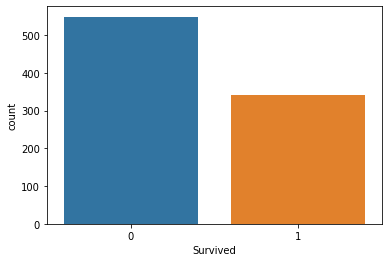

In [5]:
sns.countplot(train['Survived'])

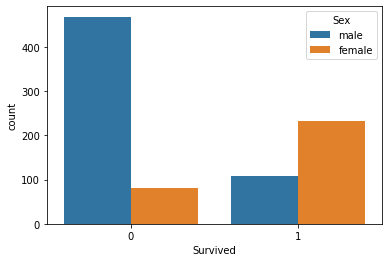

In [6]:
# show survived, but subdivide each survived bar with sex
sns.countplot(x = 'Survived', hue = 'Sex', data = train)

Number of males:  0
Number of females:  0
Total percent of males:  0.0 %
Total percent of females:  0.0 %


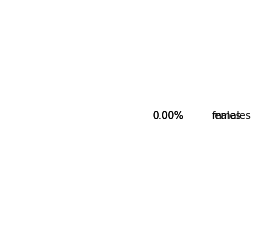

In [11]:
males = train['Sex'] == 0
females = train['Sex'] == 1

print("Number of males: ",males.sum())
print("Number of females: ",females.sum())
plt.pie([males.sum(), females.sum()], autopct = '%.2f%%',labels=("males","females"))
print("Total percent of males: ", round(males.mean()*100,2),"%")
print("Total percent of females: ", round(females.mean()*100,2),"%")

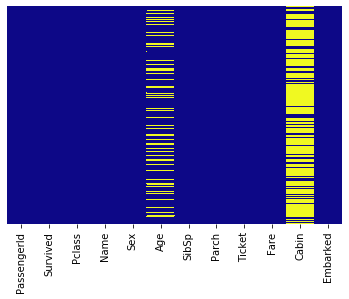

In [12]:
# heatmap of missing values
sns.heatmap(train.isnull(), yticklabels = False, cbar = False, cmap = 'plasma')

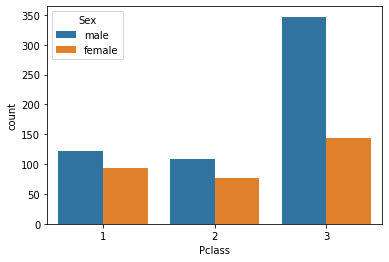

In [13]:
# plot classes
sns.countplot(x='Pclass', hue='Sex', data=train)

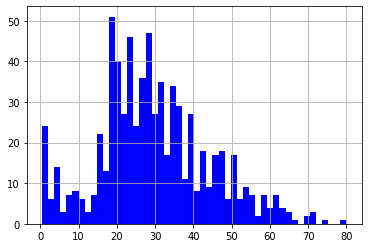

In [14]:
# on the first run we still have lots of null values for age, 
# we remove them lates replacing them with class based age averages (each class has an average age)
train['Age'].hist(bins = 50, color = 'blue')

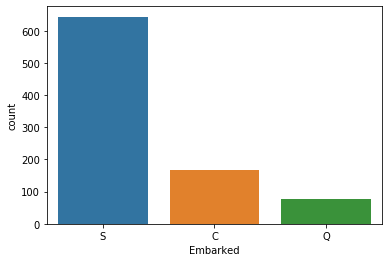

In [15]:
# port of embarkation , C = Cherbourg, Q = Queenstown, S = Southampton
sns.countplot(train['Embarked'])

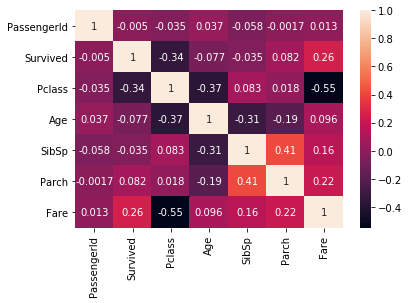

In [16]:
# draw a correlation matrix, if correlations are low it's good
# We have an additional reason to look closely to the correlation matrix 
# we are interested in imputing 177 'Age' missing values,
# What is the highest correlated variable to "Age" in absolute values?
# It is "Pclass", with |corr(Age, Pclass)| = 0.37.
sns.heatmap(train.corr(), annot = True)

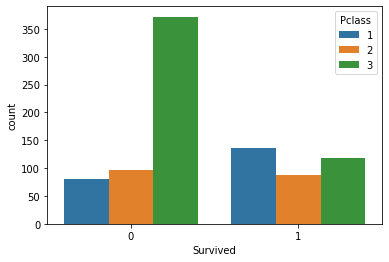

In [17]:
# we will use only 'Pclass' to input missing 'Age' values,
# since they have the highest correlation 
# show survived, but subdivide each survived bar with class
sns.countplot(x = 'Survived', hue = 'Pclass', data = train)

In [18]:
# each class has an average age
age_group = train.groupby("Pclass")["Age"]
print(age_group.median())

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64


Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447


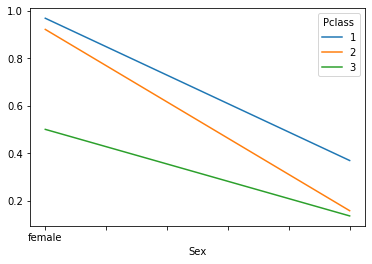

In [19]:
# 1st class has the highest survival rate, especially for females
print(train.pivot_table('Survived', index='Sex', columns='Pclass'))
train.pivot_table('Survived', index='Sex', columns='Pclass').plot()

In [20]:
# Check survival rates for each class based on age groups
age = pd.cut(train['Age'], [0,18,80])
train.pivot_table('Survived',['Sex', age], 'Pclass')

Pclass                  1         2         3
Sex    Age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [21]:
# select Age column, and only those columns where value is null
# then fill all those cells with median of age for that class
train.loc[train.Age.isnull(), 'Age'] = train.groupby("Pclass").Age.transform('median')
test.loc[test.Age.isnull(), 'Age'] = test.groupby("Pclass").Age.transform('median')

# fill the only null value in Fare column of the test set with the mean of that passenger class
test.loc[test.Fare.isnull(), 'Fare'] = test.groupby("Pclass").Fare.transform('mean')

In [22]:
# drop cabin table, it does not seem to have a lot of useful information
train.drop('Cabin', axis = 1, inplace = True)
test.drop('Cabin', axis = 1, inplace = True)

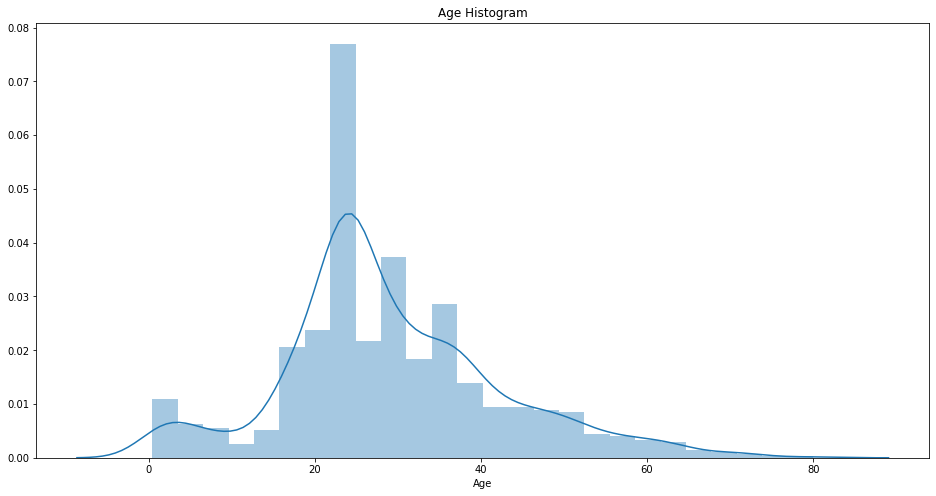

In [23]:
plt.figure(figsize = (16, 8))

sns.distplot(train["Age"])
plt.title("Age Histogram")
plt.xlabel("Age")
plt.show()

# we have lots of new 24 year olds suddenly because the age replacement based on class

In [24]:
train.isnull().sum().sort_values(ascending = False)

Embarked       2
Fare           0
Ticket         0
Parch          0
SibSp          0
Age            0
Sex            0
Name           0
Pclass         0
Survived       0
PassengerId    0
dtype: int64

In [25]:
# fill the only missing 2 values in the Embarked column, with mode of it: S
train["Embarked"] = train["Embarked"].fillna(mode(train["Embarked"]))
test["Embarked"] = test["Embarked"].fillna(mode(test["Embarked"]))

In [26]:
# Convert 'Sex' variable to integer form!
train.loc[train.Sex == 'male', 'Sex'] = 0
train.loc[train.Sex == 'female', 'Sex'] = 1

# Convert 'Embarked' variable to integer form!
train.loc[train.Embarked == 'S', 'Embarked'] = 0
train.loc[train.Embarked == 'C', 'Embarked'] = 1
train.loc[train.Embarked == 'Q', 'Embarked'] = 2

# Convert 'Sex' variable to integer form!
test.loc[test.Sex == 'male', 'Sex'] = 0
test.loc[test.Sex == 'female', 'Sex'] = 1

# Convert 'Embarked' variable to integer form!
test.loc[test.Embarked == 'S', 'Embarked'] = 0
test.loc[test.Embarked == 'C', 'Embarked'] = 1
test.loc[test.Embarked == 'Q', 'Embarked'] = 2

In [27]:
# drop these columns, it's not useful for now
train.drop(['Name', 'Ticket', 'Embarked'], axis = 1, inplace = True)
test.drop(['Name', 'Ticket', 'Embarked'], axis = 1, inplace = True)

In [28]:
train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0,3,0,22.0,1,0,7.2500
1,2,1,1,1,38.0,1,0,71.2833
2,3,1,3,1,26.0,0,0,7.9250
3,4,1,1,1,35.0,1,0,53.1000
4,5,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.0,0,0,13.0000
887,888,1,1,1,19.0,0,0,30.0000
888,889,0,3,1,24.0,1,2,23.4500
889,890,1,1,0,26.0,0,0,30.0000


In [29]:
# Local validation, we do a 80-20 split to have local training and validation set
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived'], axis = 1), 
                                                    train['Survived'], test_size = 0.2, 
                                                    random_state = 2)

In [30]:
logisticRegression = LogisticRegression(max_iter = 10000)
logisticRegression.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Make predictions on the test set

In [31]:
predictions = logisticRegression.predict(X_test)

In [32]:
# the fastest way to calculate accuracy
score = logisticRegression.score(X_test, y_test)
score

0.7877094972067039

In [33]:
confMatrix = confusion_matrix(y_test, predictions)
confMatrix # 91 True Positives, 9 False Positives, 29 False Negatives, 50 True Negatives

array([[91,  9],
       [29, 50]])

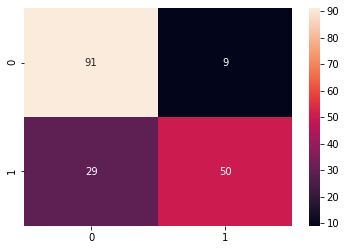

In [34]:
# draw a heatmap of the confusion matrix
sns.heatmap(confMatrix, annot=True)

In [35]:
accuracy = (91 + 50) / (91 + 9 + 29 + 50)
print('accuracy is: ' + str(round(accuracy, 4)))

accuracy is: 0.7877


## Make predictions on the actual test set and create csv for submission

In [36]:
logisticRegression = LogisticRegression(max_iter = 10000)
logisticRegression.fit(train.drop(['Survived'],axis=1), train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [37]:
test['Survived'] = logisticRegression.predict(test)

In [38]:
test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,892,3,0,34.5,0,0,7.8292,0
1,893,3,1,47.0,1,0,7.0000,0
2,894,2,0,62.0,0,0,9.6875,0
3,895,3,0,27.0,0,0,8.6625,0
4,896,3,1,22.0,1,1,12.2875,1
...,...,...,...,...,...,...,...,...
413,1305,3,0,24.0,0,0,8.0500,0
414,1306,1,1,39.0,0,0,108.9000,1
415,1307,3,0,38.5,0,0,7.2500,0
416,1308,3,0,24.0,0,0,8.0500,0


In [177]:
test[['PassengerId', 'Survived']].to_csv('data/kaggle_submission_2.csv', index = False)